# Active Image Alignment
For most use cases, each band of a multispectral capture must be aligned with the other bands in order to create meaningful data. In this tutorial, we show how to align the band to each other using open source OpenCV utilities.

Image alignment allows the combination of images into true-color (RGB) and false color (such as CIR) composites, useful for scouting using single images as well as for display and management uses. In addition to composite images, alignment allows the calculation of pixel-accurate indices such as NDVI or NDRE at the single image level which can be very useful for applications like plant counting and coverage estimations, where mosaicing artifacts may otherwise skew analysis results.

The image alignment method described below tends to work well on images with abundant image features, or areas of significant contrast. Cars, buildings, parking lots, and roads tend to provide the best results. This approach may not work well on images which contain few features or very repetitive features, such as full canopy row crops or fields of repetitive small crops such lettuce or strawberries. We will disscuss more about the advantages and disadvantages of these methods below.

The functions behind this alignment process can work with most versions of RedEdge and Altum firmware. They will work best with RedEdge (3,M,MX) versions above 3.2.0 which include the "RigRelatives" tags, and all RedEdge-P/Altum/Altum-PT imagery. These tags provide a starting point for the image transformation and can help to ensure convergence of the algorithm.

# Opening Images
As we have done in previous examples, we use the micasense.capture class to open, radiometrically correct, and visualize all the bands of a MicaSense capture.

First, we'll load the `autoreload` extension. This lets us change underlying code (such as library functions) without having to reload the entire workbook and kernel. This is useful in this workbook because the cell that runs the alignment can take a long time to run, so with the `autoreload` extension we can update the code after the alignment step for analysis and visualization without needing to re-compute the alignments each time.

In [1]:
%load_ext autoreload
%autoreload 2

Camera model: RedEdge
Bit depth: 16
Camera serial number: 1777777
Capture ID: QG538VOAubZLeGj3DSZy


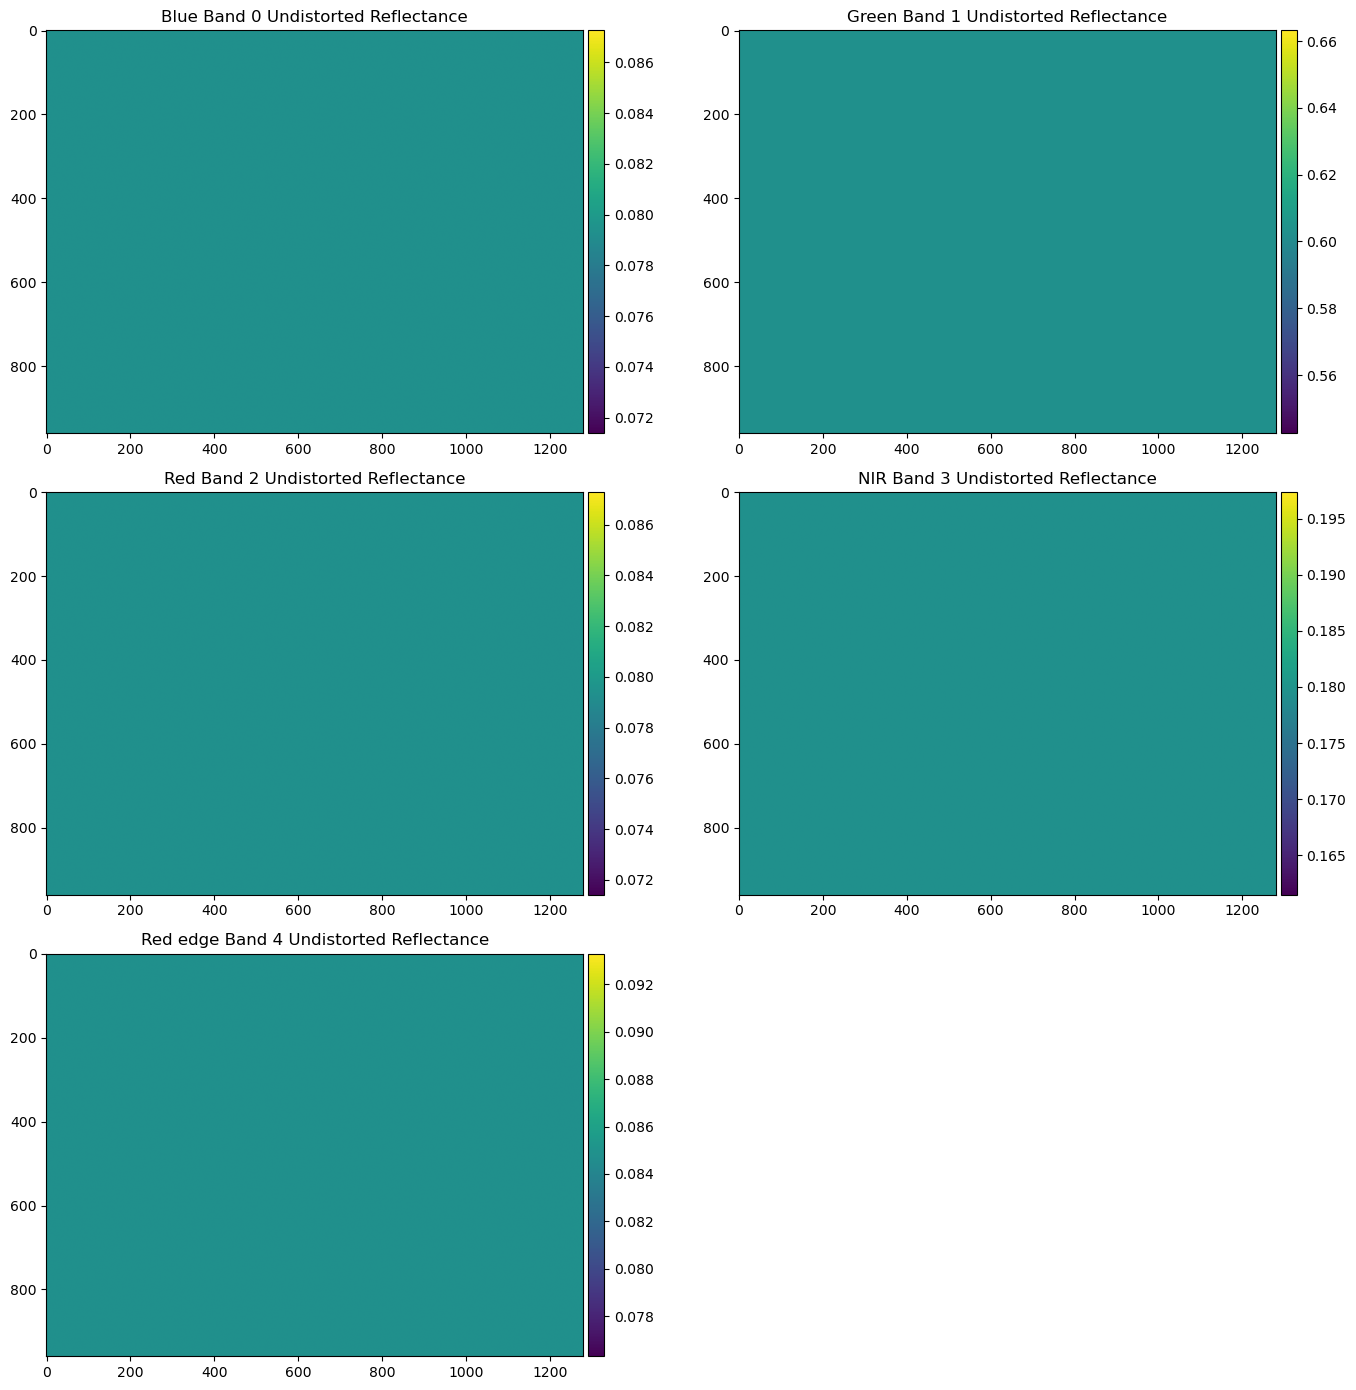

In [13]:
import os, glob
import micasense.capture as capture
%matplotlib inline
from pathlib import Path
import matplotlib.pyplot as plt
plt.rcParams["figure.facecolor"] = "w"

panelNames = None

# set your image paths here. See more here: https://docs.python.org/3/library/pathlib.html
# if using Windows, you need to an an "r" to the path like this: Path(r"C:\Files") 

# imagePath = Path("./data/REDEDGE-MX-DUAL")

# # these will return lists of image paths as strings 
# imageNames = list(imagePath.glob('IMG_0431_*.tif'))
# imageNames = [x.as_posix() for x in imageNames]

# panelNames = list(imagePath.glob('IMG_0000_*.tif'))
# panelNames = [x.as_posix() for x in panelNames]

imagePath = Path("./data/0000SET/000")
imageNames = list(imagePath.glob('IMG_0001_*.tif'))
imageNames = [x.as_posix() for x in imageNames]

#panelNames = list(imagePath.glob('IMG_0001_*.tif'))
#panelNames = [x.as_posix() for x in panelNames]

# imagePath = Path("./data/ALTUM")

# # these will return lists of image paths as strings 
# imageNames = list(imagePath.glob('IMG_0021_*.tif'))
# imageNames = [x.as_posix() for x in imageNames]

# panelNames = list(imagePath.glob('IMG_0000_*.tif'))
# panelNames = [x.as_posix() for x in panelNames]

# imagePath = Path("./data/REDEDGE-P")

# # these will return lists of image paths as strings 
# imageNames = list(imagePath.glob('IMG_0011_*.tif'))
# imageNames = [x.as_posix() for x in imageNames]

# panelNames = list(imagePath.glob('IMG_0000_*.tif'))
# panelNames = [x.as_posix() for x in panelNames]

#imagePath = Path("./data/ALTUM-PT")

# these will return lists of image paths as strings 
#imageNames = list(imagePath.glob('IMG_0010_*.tif'))
#imageNames = [x.as_posix() for x in imageNames]

#panelNames = list(imagePath.glob('IMG_0000_*.tif'))
#panelNames = [x.as_posix() for x in panelNames]


if panelNames is not None:
    panelCap = capture.Capture.from_filelist(panelNames)
else:
    panelCap = None

thecapture = capture.Capture.from_filelist(imageNames)

# get camera model for future use 
cam_model = thecapture.camera_model
# if this is a multicamera system like the RedEdge-MX Dual,
# we can combine the two serial numbers to help identify 
# this camera system later. 
if len(thecapture.camera_serials) > 1:
    cam_serial = "_".join(thecapture.camera_serials)
    print(cam_serial)
else:
    cam_serial = thecapture.camera_serial
    
print("Camera model:",cam_model)
print("Bit depth:", thecapture.bits_per_pixel)
print("Camera serial number:", cam_serial)
print("Capture ID:",thecapture.uuid)

# determine if this sensor has a panchromatic band 
if cam_model == 'RedEdge-P' or cam_model == 'Altum-PT':
    panchroCam = True
else:
    panchroCam = False
    panSharpen = False 

if panelCap is not None:
    if panelCap.panel_albedo() is not None:
        panel_reflectance_by_band = panelCap.panel_albedo()
    else:
        panel_reflectance_by_band = [0.49]*len(thecapture.eo_band_names()) #RedEdge band_index order
    panel_irradiance = panelCap.panel_irradiance(panel_reflectance_by_band)  
    irradiance_list = panelCap.panel_irradiance(panel_reflectance_by_band) + [0] # add to account for uncalibrated LWIR band, if applicable
    img_type = "reflectance"
    thecapture.plot_undistorted_reflectance(panel_irradiance)
else:
    if thecapture.dls_present():
        img_type='reflectance'
        irradiance_list = thecapture.dls_irradiance() + [0]
        thecapture.plot_undistorted_reflectance(thecapture.dls_irradiance())
    else:
        img_type = "radiance"
        thecapture.plot_undistorted_radiance() 
        irradiance_list = None

# Check for existing warp matrices 
If we have already successfully aligned captures from this specific camera, we can typically save some time and use the alignment warp matrices for other captures from the same camera

In [14]:
from skimage.transform import ProjectiveTransform
import numpy as np

if panchroCam:
    warp_matrices_filename = str(cam_serial) + "_warp_matrices_SIFT.npy"
else:
    warp_matrices_filename = str(cam_serial) + "_warp_matrices_opencv.npy"

if Path('./' + warp_matrices_filename).is_file():
    print("Found existing warp matrices for camera", cam_serial)
    load_warp_matrices = np.load(warp_matrices_filename, allow_pickle=True)
    loaded_warp_matrices = []
    for matrix in load_warp_matrices: 
        if panchroCam:
            transform = ProjectiveTransform(matrix=matrix.astype('float64'))
            loaded_warp_matrices.append(transform)
        else:
            loaded_warp_matrices.append(matrix.astype('float32'))
    print("Warp matrices successfully loaded.")

    if panchroCam:
        warp_matrices_SIFT = loaded_warp_matrices
    else:
        warp_matrices = loaded_warp_matrices
else:
    print("No existing warp matrices found. Create them later in the notebook.")
    warp_matrices_SIFT = False
    warp_matrices = False

No existing warp matrices found. Create them later in the notebook.


In [18]:
warp_mode = cv2.MOTION_HOMOGRAPHY  # ou cv2.MOTION_AFFINE
number_of_iterations = 5000
termination_eps = 1e-10

criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations, termination_eps)

#(cc, warp_matrix) = cv2.findTransformECC(thecapture, warp_matrix, warp_mode, criteria)


['data/0000SET/000/IMG_0001_4.tif', 'data/0000SET/000/IMG_0001_2.tif', 'data/0000SET/000/IMG_0001_3.tif', 'data/0000SET/000/IMG_0001_1.tif', 'data/0000SET/000/IMG_0001_5.tif']
image valide
image valide
image valide
image valide
image valide


In [21]:
import micasense.imageutils as imageutils

# Exemple d'alignement avec le SDK Micasense
def align_capture(capture, ref_index=0, max_iterations=5000, warp_mode=cv2.MOTION_HOMOGRAPHY, pyramid_levels=3):
    try:
        warp_matrices, alignment_pairs = imageutils.align_capture(
            capture,
            ref_index=ref_index,
            max_iterations=max_iterations,
            warp_mode=warp_mode,
            pyramid_levels=pyramid_levels
        )
        return warp_matrices, alignment_pairs
    except cv2.error as e:
        print(f"Erreur lors de l'alignement des images : {e}")
        return None, None

# Assurez-vous que `thecapture` est correctement initialisé
warp_matrices, alignment_pairs = align_capture(thecapture)
if warp_matrices is not None:
    print("Alignement terminé avec succès.")
else:
    print("Échec de l'alignement.")


Finished aligning band 0
Erreur lors de l'alignement des images : OpenCV(4.8.1) /home/conda/feedstock_root/build_artifacts/libopencv_1698890330579/work/modules/video/src/ecc.cpp:574: error: (-7:Iterations do not converge) NaN encountered. in function 'findTransformECC'

Échec de l'alignement.


# Unwarp and Align (OpenCV method for RedEdge3/M/MX/Dual and original Altum)
Alignment is a three-step process:

Images are unwarped using the built-in lens calibration
A transformation is found to align each band to a common band
The aligned images are combined and cropped, removing pixels which don't overlap in all bands.
We provide utilities to find the alignment transformations within a single capture. Our experience shows that once a good alignment transformation is found, it tends to be stable over a flight and, in most cases, over many flights. The transformation may change if the camera undergoes a shock event (such as a hard landing or drop) or if the temperature changes substantially between flights. In these events, a new transformation may need to be found.

Further, since this approach finds a 2-dimensional (affine) transformation between images, it won't work when the parallax between bands results in a 3-dimensional depth field. This can happen if very close to the target or when targets are visible at significantly different ranges, such as a nearby tree or building against a background much farther way. In these cases, it will be necessary to use photogrammetry techniques to find a 3-dimensional mapping between images.

For best alignment results it's good to select a capture which has features which visible in all bands. Man-made objects such as cars, roads, and buildings tend to work very well, while captures of only repeating crop rows tend to work poorly. Remember, once a good transformation has been found for flight, it can be generally be applied across all of the images.

It's also good to use an image for alignment which is taken near the same level above ground as the rest of the flights. Above approximately 35m AGL, the alignment will be consistent. However, if images taken closer to the ground are used, such as panel images, the same alignment transformation will not work for the flight data.

In [20]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
import micasense.imageutils as imageutils
import micasense.plotutils as plotutils

# We use a different alignment method for RedEdge-P and Altum-PT, 
# so if the imagery is from this kind of camera, skip this step 
if not panchroCam:
    st = time.time()
    # set to True if you'd like to ignore existing warp matrices and create new ones
    regenerate = True    
    pyramid_levels = 0 # for images with RigRelatives, setting this to 0 or 1 may improve alignment
    max_alignment_iterations = 10

    # match_index: 
    # for non-panchromatic cameras we want to use band 1, which is green 
    # the green band has zero rig relative offsets 
    # NOTE: These band numbers are zero-indexed 
    # special parameters for RedEdge-MX dual camera system 
    if len(thecapture.eo_band_names()) == 10:
        print("is 10 band")
        pyramid_levels = 3
        match_index = 4
        max_alignment_iterations = 20
    else: 
        match_index = 1

    warp_mode = cv2.MOTION_HOMOGRAPHY # MOTION_HOMOGRAPHY or MOTION_AFFINE. For Altum images only use HOMOGRAPHY

    print("Aligning images. Depending on settings this can take from a few seconds to many minutes")
    # Can potentially increase max_iterations for better results, but longer runtimes
    if warp_matrices and not regenerate:
        print("Using existing warp matrices...")
        try:
            irradiance = panel_irradiance+[0]
        except NameError:
            irradiance = None
    else:
        warp_matrices, alignment_pairs = imageutils.align_capture(thecapture,
                                                              ref_index = match_index,
                                                              max_iterations = max_alignment_iterations,
                                                              warp_mode = warp_mode,
                                                              pyramid_levels = pyramid_levels)

    print("Finished Aligning")
    et = time.time()
    elapsed_time = et - st
    print('Alignment time:', int(elapsed_time), 'seconds')

Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 1


error: OpenCV(4.8.1) /home/conda/feedstock_root/build_artifacts/libopencv_1698890330579/work/modules/video/src/ecc.cpp:574: error: (-7:Iterations do not converge) NaN encountered. in function 'findTransformECC'


# Crop Aligned Images and create aligned capture stack 
After finding image alignments, we may need to remove pixels around the edges which aren't present in every image in the capture. To do this we use the affine transforms found above and the image distortions from the image metadata. OpenCV provides a couple of handy helpers for this task in the cv2.undistortPoints() and cv2.transform() methods. These methods take a set of pixel coordinates and apply our undistortion matrix and our affine transform, respectively. So, just as we did when registering the images, we first apply the undistortion process to the coordinates of the image borders, then we apply the affine transformation to that result. The resulting pixel coordinates tell us where the image borders end up after this pair of transformations, and we can then crop the resultant image to these coordinates.

In [ ]:
if not panchroCam:
    cropped_dimensions, edges = imageutils.find_crop_bounds(thecapture, warp_matrices, warp_mode=warp_mode, reference_band=match_index)
    print("Cropped dimensions:",cropped_dimensions)
    im_aligned = thecapture.create_aligned_capture(warp_matrices=warp_matrices, motion_type=warp_mode, img_type=img_type)


TypeError: 'bool' object is not iterable

# Alignment and pan-sharpening for RedEdge-P and Altum-PT
For older cameras we use OpenCV for capture alignment. For RedEdge-P and Altum-PT, we use SIFT (scale-invariant feature transform). We will use SIFT to create the warp matrices, then use these warp matrices to align the capture. See more here: 
https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_sift.html
https://en.wikipedia.org/wiki/Scale-invariant_feature_transform

For sensors with a panchromatic band (Altum-PT or RedEdge-P), we may wish to create a pan-sharpened stack. This example uses a linear interpolation method for pan-sharpening.

The `radiometric_pan_sharpen` function takes in the SIFT warp matrices and outputs an upsampled image stack (all bands are changed to the resolution of the panchromatic sensor) and a pan-sharpened stack. 

Note: it is important to choose an initial alignment image that has a lot of straight, manmade features, such as roads or buildings. Trying to align a capture that is strictly vegetation will take a long time and may not be very good. This process can take a while, depending on how feature-rich the capture is. We have seen some Altum-PT captures align after 2 minutes, and some can take upwards of 30 minutes. Be patient! Once an alignment has been found, it can be used on other captures from the same camera, and the alignment process will be much faster. 

In [ ]:
# from micasense.imageutils import brovey_pan_sharpen,radiometric_pan_sharpen
from skimage.transform import ProjectiveTransform
import time

if panchroCam: 
    # set to True if you'd like to ignore existing warp matrices and create new ones
    regenerate = True
    st = time.time()
    if not warp_matrices_SIFT or regenerate:
        print("Generating new warp matrices...")
        warp_matrices_SIFT = thecapture.SIFT_align_capture(min_matches = 10)
        
    sharpened_stack, upsampled = thecapture.radiometric_pan_sharpened_aligned_capture(warp_matrices=warp_matrices_SIFT, irradiance_list=irradiance_list, img_type=img_type)
    
# we can also use the Rig Relatives from the image metadata to do a quick, rudimentary alignment 
#     warp_matrices0=thecapture.get_warp_matrices(ref_index=5)
#     sharpened_stack,upsampled = radiometric_pan_sharpen(thecapture,warp_matrices=warp_matrices0)

    print("Pansharpened shape:", sharpened_stack.shape)
    print("Upsampled shape:", upsampled.shape)
    # re-assign to im_aligned to match rest of code 
    im_aligned = upsampled
    et = time.time()
    elapsed_time = et - st
    print('Alignment and pan-sharpening time:', int(elapsed_time), 'seconds')

# Save warp matrices
Once an alignment for your camera has been found, it can be saved to a file for later use with this notebook. It can also be used on the Batch Alignment notebook for aligning all of the captures from an entire flight.

In [ ]:
import numpy
import skimage
from skimage.transform import warp,matrix_transform,resize,FundamentalMatrixTransform,estimate_transform,ProjectiveTransform

if panchroCam:
    working_wm = warp_matrices_SIFT
else:
    working_wm = warp_matrices
if not Path('./' + warp_matrices_filename).is_file() or regenerate:
    temp_matrices = []
    for x in working_wm:
        if isinstance(x, numpy.ndarray):
            temp_matrices.append(x)
        if isinstance(x, skimage.transform._geometric.ProjectiveTransform):
            temp_matrices.append(x.params)
    np.save(warp_matrices_filename, np.array(temp_matrices, dtype=object), allow_pickle=True)
    print("Saved to", Path('./' + warp_matrices_filename).resolve())
else:
    print("Matrices already exist at",Path('./' + warp_matrices_filename).resolve())

# Multispectral band histogram 
We can compare the radiance between multispectral bands, and between upsampled/pansharpened in the case of RedEdge-P and Altum-PT

In [ ]:
theColors = {'Blue': 'blue', 'Green': 'green', 'Red': 'red', \
             'Red edge': 'maroon', 'NIR': 'purple', 'Panchro': 'yellow', 'PanchroB': 'orange',\
            'Red edge-740': 'salmon', 'Red Edge': 'maroon', 'Blue-444': 'aqua', \
             'Green-531': 'lime', 'Red-650': 'lightcoral', 'Red edge-705':'brown'}

eo_count = len(thecapture.eo_indices())
multispec_min = np.min(np.percentile(im_aligned[:,:,1:eo_count].flatten(),0.01))
multispec_max = np.max(np.percentile(im_aligned[:,:,1:eo_count].flatten(), 99.99))

theRange = (multispec_min,multispec_max)

fig, axis = plt.subplots(1, 1, figsize=(10,4))
for x,y in zip(thecapture.eo_indices(),thecapture.eo_band_names()):
    axis.hist(im_aligned[:,:,x].ravel(), bins=512, range=theRange, \
              histtype="step", label=y, color=theColors[y], linewidth=1.5)
plt.title("Multispectral histogram (radiance)")
axis.legend()
plt.show()

if panchroCam:
    eo_count = len(thecapture.eo_indices())
    multispec_min = np.min(np.percentile(sharpened_stack[:,:,1:eo_count].flatten(),0.01))
    multispec_max = np.max(np.percentile(sharpened_stack[:,:,1:eo_count].flatten(), 99.99))

    theRange = (multispec_min,multispec_max)

    fig, axis = plt.subplots(1, 1, figsize=(10,4))
    for x,y in zip(thecapture.eo_indices(),thecapture.eo_band_names()):
        axis.hist(sharpened_stack[:,:,x].ravel(), bins=512, range=theRange, \
                  histtype="step", label=y, color=theColors[y], linewidth=1.5)
    plt.title("Pan-sharpened multispectral histogram (radiance)")
    axis.legend()
    plt.show()

NameError: name 'im_aligned' is not defined

# Visualize Aligned Images
Once the transformation has been found, it can be verified by compositing the aligned images to check alignment. The image 'stack' containing all bands can also be exported to a multi-band TIFF file for viewing in external software such as QGIS. Useful composites are a naturally colored RGB as well as color infrared, or CIR.

In [ ]:
# figsize=(30,23) # use this size for full-image-resolution display
figsize=(16,13)   # use this size for export-sized display

rgb_band_indices = [thecapture.band_names_lower().index('red'),
                    thecapture.band_names_lower().index('green'),
                    thecapture.band_names_lower().index('blue')]
cir_band_indices = [thecapture.band_names_lower().index('nir'),
                    thecapture.band_names_lower().index('red'),
                    thecapture.band_names_lower().index('green')]

# Create normalized stacks for viewing
im_display = np.zeros((im_aligned.shape[0],im_aligned.shape[1],im_aligned.shape[2]), dtype=np.float32)
im_min = np.percentile(im_aligned[:,:,rgb_band_indices].flatten(), 0.5)  # modify these percentiles to adjust contrast
im_max = np.percentile(im_aligned[:,:,rgb_band_indices].flatten(), 99.5)  # for many images, 0.5 and 99.5 are good values

if panchroCam:
    im_display_sharp = np.zeros((sharpened_stack.shape[0],sharpened_stack.shape[1],sharpened_stack.shape[2]), dtype=np.float32 )
    im_min_sharp = np.percentile(sharpened_stack[:,:,rgb_band_indices].flatten(), 0.5)  # modify these percentiles to adjust contrast
    im_max_sharp = np.percentile(sharpened_stack[:,:,rgb_band_indices].flatten(), 99.5)  # for many images, 0.5 and 99.5 are good values


# for rgb true color, we use the same min and max scaling across the 3 bands to 
# maintain the "white balance" of the calibrated image
for i in rgb_band_indices:
    im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i], im_min, im_max)
    if panchroCam: 
        im_display_sharp[:,:,i] = imageutils.normalize(sharpened_stack[:,:,i], im_min_sharp, im_max_sharp)

rgb = im_display[:,:,rgb_band_indices]

if panchroCam:
    rgb_sharp = im_display_sharp[:,:,rgb_band_indices]

nir_band = thecapture.band_names_lower().index('nir')
red_band = thecapture.band_names_lower().index('red')

ndvi = (im_aligned[:,:,nir_band] - im_aligned[:,:,red_band]) / (im_aligned[:,:,nir_band] + im_aligned[:,:,red_band])

# for cir false color imagery, we normalize the NIR,R,G bands within themselves, which provides
# the classical CIR rendering where plants are red and soil takes on a blue tint
for i in cir_band_indices:
    im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i])

cir = im_display[:,:,cir_band_indices]
if panchroCam:
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=figsize)
else:
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
ax1.set_title("Red-Green-Blue Composite")
ax1.imshow(rgb)
if panchroCam:
    ax2.set_title("Red-Green-Blue Composite (pan-sharpened)")
    ax2.imshow(rgb_sharp)

fig, (ax3,ax4) = plt.subplots(1, 2, figsize=figsize)
ax3.set_title("NDVI")
ax3.imshow(ndvi)
ax4.set_title("Color Infrared (CIR) Composite")
ax4.imshow(cir)

# set custom lims if you want to zoom in to image to see more detail 
# this is useful for comparing upsampled and pan-sharpened stacks 
# custom_xlim=(1500,2000)
# custom_ylim=(2000,1500)
# plt.setp([ax1,ax2,ax3,ax4], xlim=custom_xlim, ylim=custom_ylim)

plt.show()

# Image Enhancement
There are many techniques for image enhancement, but one which is commonly used to improve the visual sharpness of imagery is the unsharp mask. Here, we apply an unsharp mask to the RGB image to improve the visualization, and then apply a gamma curve to make the darkest areas brighter.

In [ ]:
if panchroCam:
    rgb = rgb_sharp
# Create an enhanced version of the RGB render using an unsharp mask
gaussian_rgb = cv2.GaussianBlur(rgb, (9,9), 10.0)
gaussian_rgb[gaussian_rgb<0] = 0
gaussian_rgb[gaussian_rgb>1] = 1
unsharp_rgb = cv2.addWeighted(rgb, 1.5, gaussian_rgb, -0.5, 0)
unsharp_rgb[unsharp_rgb<0] = 0
unsharp_rgb[unsharp_rgb>1] = 1

# Apply a gamma correction to make the render appear closer to what our eyes would see
gamma = 1.4
gamma_corr_rgb = unsharp_rgb**(1.0/gamma)
fig = plt.figure(figsize=figsize)
plt.imshow(gamma_corr_rgb, aspect='equal')
plt.axis('off')
plt.show()

# Stack Export
We can easily export the stacks into an image using the GDAL library (http://www.glal.org). Once exported, these image stacks can be opened in software such as QGIS and raster operations such as NDVI or NDRE computation can be done in that software. The stacks include geographic information. 

If you prefer, you may set `sort_by_wavelength` to `True` in the `save_capture_as_stack` function.

Unless otherwise specified, this will save in your working folder, that is your `imageprocessing` directory.

In [ ]:
#set output name to unique capture ID, e.g. FWoNSvgDNBX63Xv378qs
outputName = thecapture.uuid

st = time.time()
if panchroCam:
    # in this example, we can export both a pan-sharpened stack and an upsampled stack
    # so you can compare them in GIS. In practice, you would typically only output the pansharpened stack 
    thecapture.save_capture_as_stack(outputName+"-pansharpened.tif", sort_by_wavelength=True, pansharpen=True)
    thecapture.save_capture_as_stack(outputName+"-upsampled.tif", sort_by_wavelength=True, pansharpen=False)
else:
    thecapture.save_capture_as_stack(outputName+"-noPanels.tif", sort_by_wavelength=True)

et = time.time()
elapsed_time = et - st
print("Time to save stacks:", int(elapsed_time), "seconds.")

# NDVI Computation
For raw index computation on single images, the `numpy` package provides a simple way to do math and simple visualization on images. Below, we compute and visualize an image histogram, and then use that to pick a color map range for visualizing the NDVI of an image.

## Plant Classification
After computing the NDVI and prior to displaying it, we use a very rudimentary method for focusing on the plants and removing the soil and shadow information from our images and histograms. Below, we remove non-plant pixels by setting to zero any pixels in the image where the NIR reflectance is less than 20%. This helps to ensure that the NDVI and NDRE histograms aren't skewed substantially by soil noise.

In [ ]:
from micasense import plotutils
import matplotlib.pyplot as plt

nir_band = thecapture.band_names_lower().index('nir')
red_band = thecapture.band_names_lower().index('red')

thelayer = im_aligned
if panchroCam:
    thelayer = sharpened_stack
np.seterr(divide='ignore', invalid='ignore') # ignore divide by zero errors in the index calculation

# Compute Normalized Difference Vegetation Index (NDVI) from the NIR(3) and RED (2) bands
ndvi = (thelayer[:,:,nir_band] - thelayer[:,:,red_band]) / (thelayer[:,:,nir_band] + thelayer[:,:,red_band])
print("Image type:",img_type)

# remove shadowed areas (mask pixels with NIR reflectance < 20%))
# this does not seem to work on panchro stacks 
if img_type == 'reflectance':
    ndvi = np.ma.masked_where(thelayer[:,:,nir_band] < 0.20, ndvi) 
elif img_type == 'radiance':
    lower_pct_radiance = np.percentile(thelayer[:,:,nir_band],  10.0)
    ndvi = np.ma.masked_where(thelayer[:,:,nir_band] < lower_pct_radiance, ndvi) 
# Compute and display a histogram
# ndvi_hist_min = np.min(ndvi) 
# ndvi_hist_max = np.max(ndvi) 
ndvi_hist_min = np.min(np.percentile(ndvi,0.5))
ndvi_hist_max = np.max(np.percentile(ndvi,99.5))
fig, axis = plt.subplots(1, 1, figsize=(10,4))
axis.hist(ndvi.ravel(), bins=512, range=(ndvi_hist_min, ndvi_hist_max))
plt.title("NDVI Histogram")
plt.show()

min_display_ndvi = 0.45 # further mask soil by removing low-ndvi values
#min_display_ndvi = np.percentile(ndvi.flatten(),  5.0)  # modify with these percentilse to adjust contrast
max_display_ndvi = np.percentile(ndvi.flatten(), 99.5)  # for many images, 0.5 and 99.5 are good values
masked_ndvi = np.ma.masked_where(ndvi < min_display_ndvi, ndvi)

#reduce the figure size to account for colorbar
figsize=np.asarray(figsize) - np.array([3,2])

#plot NDVI over an RGB basemap, with a colorbar showing the NDVI scale
fig, axis = plotutils.plot_overlay_withcolorbar(gamma_corr_rgb, 
                                    masked_ndvi, 
                                    figsize = (14,7), 
                                    title = 'NDVI filtered to only plants over RGB base layer',
                                    vmin = min_display_ndvi,
                                    vmax = max_display_ndvi)
fig.savefig(thecapture.uuid+'_ndvi_over_rgb.png')

# NDRE Computation
In the same manner, we can compute, filter, and display another index useful for MicaSense cameras, the Normalized Difference Red Edge (NDRE) index. We also filter out shadows and soil to ensure our display focuses only on the plant health.

In [ ]:
# Compute Normalized Difference Red Edge Index from the NIR(3) and RedEdge(4) bands
rededge_band = thecapture.band_names_lower().index('red edge')
ndre = (thelayer[:,:,nir_band] - thelayer[:,:,rededge_band]) / (thelayer[:,:,nir_band] + thelayer[:,:,rededge_band])

# Mask areas with shadows and low NDVI to remove soil
masked_ndre = np.ma.masked_where(ndvi < min_display_ndvi, ndre)

# Compute a histogram
ndre_hist_min = np.min(np.percentile(masked_ndre,0.5))
ndre_hist_max = np.max(np.percentile(masked_ndre,99.5))
fig, axis = plt.subplots(1, 1, figsize=(10,4))
axis.hist(masked_ndre.ravel(), bins=512, range=(ndre_hist_min, ndre_hist_max))
plt.title("NDRE Histogram (filtered to only plants)")
plt.show()

min_display_ndre = np.percentile(masked_ndre, 5)
max_display_ndre = np.percentile(masked_ndre, 99.5)

fig, axis = plotutils.plot_overlay_withcolorbar(gamma_corr_rgb, 
                                    masked_ndre, 
                                    figsize=(14,7), 
                                    title='NDRE filtered to only plants over RGB base layer',
                                    vmin=min_display_ndre,vmax=max_display_ndre)
fig.savefig(thecapture.uuid+'_ndre_over_rgb.png')

# Thermal Imagery
If our image is from an Altum or Altum-PT and includes a thermal band, we can display the re-sampled and aligned thermal data over the RGB data to maintain the context of the thermal information.


In [ ]:
if len(thecapture.lw_indices()) > 0:
    lwir_band = thecapture.band_names_lower().index('lwir')

    # by default we don't mask the thermal, since it's native resolution is much lower than the MS
    if panchroCam:
        masked_thermal = sharpened_stack[:,:,lwir_band]
    else:
        masked_thermal = im_aligned[:,:,lwir_band]
    # Alternatively we can mask the thermal only to plants here, which is useful for large contiguous areas
    # masked_thermal = np.ma.masked_where(ndvi < 0.45, im_aligned[:,:,5])


    # Compute a histogram
    fig, axis = plt.subplots(1, 1, figsize=(10,4))
    axis.hist(masked_thermal.ravel(), bins=512, range=(np.min(np.percentile(masked_thermal,1)), np.max(np.percentile(masked_thermal,99))))
    plt.title("Thermal Histogram")
    plt.show()

    min_display_therm = np.percentile(masked_thermal, 1)
    max_display_therm = np.percentile(masked_thermal, 99)

    fig, axis = plotutils.plot_overlay_withcolorbar(gamma_corr_rgb,
                                        masked_thermal, 
                                        figsize=(14,7), 
                                        title='Temperature over True Color',
                                        vmin=min_display_therm,vmax=max_display_therm,
                                        overlay_alpha=0.25,
                                        overlay_colormap='jet',
                                        overlay_steps=16,
                                        display_contours=True,
                                        contour_steps=16,
                                        contour_alpha=.4,
                                        contour_fmt="%.0fC")
    fig.savefig(thecapture.uuid+'_thermal_over_rgb.png')

# Red vs NIR Reflectance
Finally, we show a classic agricultural remote sensing output in the tassled cap plot. This plot can be useful for visualizing row crops and plots the Red Reflectance channel on the X-axis against the NIR reflectance channel on the Y-axis. This plot also clearly shows the line of the soil in that space. The tassled cap view isn't very useful for this arid data set; however, we can see the "badge of trees" of high NIR reflectance and relatively low red reflectance. This provides an example of one of the uses of aligned images for single capture analysis.

In [ ]:
x_band = red_band
y_band = nir_band
x_max = np.max(np.percentile(im_aligned[:,:,x_band],99.99))
y_max = np.max(np.percentile(im_aligned[:,:,y_band],99.99))

fig = plt.figure(figsize=(12,12))
plt.hexbin(im_aligned[:,:,x_band],im_aligned[:,:,y_band],gridsize=640,bins='log',extent=(0,x_max,0,y_max))
ax = fig.gca()
ax.set_xlim([0,x_max])
ax.set_ylim([0,y_max])
plt.xlabel("{} Reflectance".format(thecapture.band_names()[x_band]))
plt.ylabel("{} Reflectance".format(thecapture.band_names()[y_band]))
plt.show()

if panchroCam:
    x_band = red_band
    y_band = nir_band
    x_max = np.max(np.percentile(sharpened_stack[:,:,x_band],99.99))
    y_max = np.max(np.percentile(sharpened_stack[:,:,y_band],99.99))

    fig = plt.figure(figsize=(12,12))
    plt.hexbin(sharpened_stack[:,:,x_band],sharpened_stack[:,:,y_band],gridsize=640,bins='log',extent=(0,x_max,0,y_max))
    ax = fig.gca()
    ax.set_xlim([0,x_max])
    ax.set_ylim([0,y_max])
    plt.xlabel("{} Reflectance (pan-sharpened)".format(thecapture.band_names()[x_band]))
    plt.ylabel("{} Reflectance (pan-sharpened)".format(thecapture.band_names()[y_band]))
    plt.show()

# Print warp_matrices for usage elsewhere, such as Batch Processing
Lastly, we output the `warp_matrices` that we got for this image stack for usage elsewhere. Currently, these can be used in the Batch Processing.ipynb notebook to save reflectance-compensated stacks of images to a directory.

In [ ]:
if panchroCam:
    print(warp_matrices_SIFT)
else:
    print(warp_matrices)